# Lab4

## Data Preprocessing

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay)
%matplotlib inline
#notebook 单元格内直接显示 Matplotlib 生成的图像

plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")
print("Evironment Setup Complete")


train_raw = pd.read_csv('training.csv')
test_raw = pd.read_csv('testing.csv')

#use features b1-b9 and all classes in the “Forest type mapping data set”
#def filter_classes(df):
#    return df[df['class'].isin(['s','d'])].copy()#创建数据的独立副本，不影响原数据

# Drop pred_minus_obs columns
cols_to_drop = [c for c in train_raw.columns if c.startswith('pred_minus_obs')]
train_df = train_raw.drop(columns = cols_to_drop)
test_df = test_raw.drop(columns = cols_to_drop)


#显示数据概览
print("\nData Overview:")
print(f"Training set shape: {train_df.shape}")#.shape 是一个 属性，它返回 (行数, 列数) 的 元组 (tuple)。
print(f"Test set shape: {test_df.shape}")
print("\nCategory distribution:")
print("Training set:\n", train_df['class'].value_counts())
print("Test set:\n", test_df['class'].value_counts())

#分离特征和标签
feature_cols = [f'b{i}' for i in range(1,10)]#创建一个包含 b1 到 b9 的特征名称列表
X_train = train_df[feature_cols]
y_train = train_df['class']
X_test = test_df[feature_cols]
y_test = test_df['class']

print(X_train.head())

#数据备份
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

Evironment Setup Complete

Data Overview:
Training set shape: (325, 10)
Test set shape: (198, 10)

Category distribution:
Training set:
 class
s    136
d    105
o     46
h     38
Name: count, dtype: int64
Test set:
 class
s    59
d    54
h    48
o    37
Name: count, dtype: int64
   b1  b2  b3   b4  b5   b6   b7  b8  b9
0  67  51  68  115  69  111  136  31  67
1  67  28  51   99  50   97   82  26  59
2  63  26  50   95  49   91   81  26  57
3  63  42  63   97  66  108  111  28  59
4  46  27  50   83  51   90   76  26  56


# The other way from the solution

### Data preprocessing

In [20]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('training.csv')
df_test = pd.read_csv('testing.csv')

# function for cleaning data to get fearture b1-b9
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df[['class'] + [f'b{i}' for i in range(1, 10)]]

df_train = clean_cols(df_train)
df_test = clean_cols(df_test)

# Saperate the data to feature and target
X_train, y_train = df_train[[f'b{i}' for i in range(1,10)]], df_train['class']
X_test, y_test = df_test[[f'b{i}' for i in range(1,10)]], df_test['class']


## create a helper function
From the lab sheet 4, ask to do the task 2-4 multiple times at following tasks, so we make a function to cover task 2-4

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

#built a functionn
def helper_function(pipeline, param_grid):
    model = GridSearchCV(
        pipeline,
        param_grid = param_grid,
        cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42),
        scoring = 'f1_weighted',
        refit = True
    )

    model.fit(X_train, y_train)
    
    # To get the best parameter of the current model
    print(f'optimal hyperparameter values: {model.best_params_}\n')#f让字符串中可以插入变量。{}里的变量会被计算出其值

    cv_df = pd.DataFrame({
        'fold': range(1,4),
        'Validation F1': [f'{model.cv_results_[f"split{i}_test_score"][model.best_index_]:.3f}' for i in range(3)]
    })
    #使用DataFrame的数据结构。类似一个具有行列的表格
    #列 fold 范围是1-3.range（1，4），表从1开始，3结束，不包括4
    #列 Validation F1 数据计算流程如下
        #获取 model 中所有的交叉验证结果字典
        #通过 split{i} 获取第i折的数据数组array
        #通过 .best_index_ 获取最佳超参数组合对应的折索引，并从上面的array中获取这个索引对应的值。
        #最后展示的为 一个数据表格
        
    print(cv_df.to_string(index=False)+'\n')#打印出 cv_df DataFrame 的内容，并且不显示行索引

    #计算准确率
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))

    print(f'Train accuracy: {train_accuracy:.3f}')
    print(f'Test accuracy: {test_accuracy:.3f}')

    #绘制confusion matrix
    ConfusionMatrixDisplay.from_estimator( #自动调用 model 的 predict() 计算 y_pred
        model,
        X_test,
        y_test,
        display_labels=model.classes_, # 用来显示标签的名称，通常是模型的类别
    )

    plt.title('Test set')

    return model

## Task 1-4  Scaled SCV 标准化
Apply feature scaling using the StandardScaler

optimal hyperparameter values: {'svc__C': 100.0, 'svc__kernel': 'linear'}

 fold Validation F1
    1         0.889
    2         0.915
    3         0.868

Train accuracy: 0.908
Test accuracy: 0.904


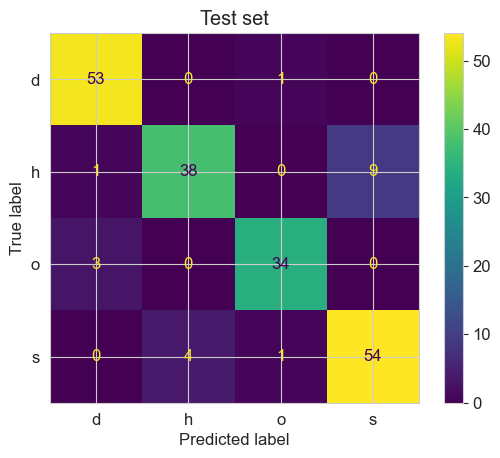

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

#标准化（StandardScaler）：适用于大多数机器学习模型，特别是当数据服从正态分布时更合适。
#归一化（Min-Max）：适用于深度学习或需要确保数据在相同范围的模型（如 SVM支持向量机）。

model_svc_scaled = helper_function(
    make_pipeline(MinMaxScaler(), SVC(decision_function_shape='ovo', random_state=42)),
    {
        'svc__C': np.logspace(-3, 3, 7),#这里是双下划线
        'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    }
)



### Task 5 without doing feature scaling

optimal hyperparameter values: {'svc__C': 0.01, 'svc__kernel': 'linear'}

 fold Validation F1
    1         0.880
    2         0.925
    3         0.859

Train accuracy: 0.905
Test accuracy: 0.904


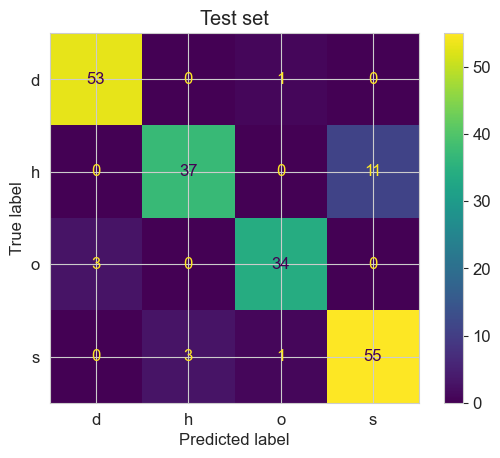

In [25]:
model_svc_unscaled = helper_function(
    make_pipeline(SVC(decision_function_shape='ovo', random_state=42)),
    {
        'svc__C': np.logspace(-3, 3, 7),#这里是双下划线
        'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    }
)

### Task 6

- SVMs are sensitive to feature scaling, but b1 , ..., b9 are on similar scales already
- 支持向量机对特征缩放很敏感，但是b1，…, b9已经达到了类似的规模
- The quadratic programming problem is much faster to solve after scaling
- 缩放后的二次规划问题求解速度更快
- In this case we can skip feature scaling if we're careful, but it certainly doesn't hurt to do it.
- 在这种情况下，如果我们小心的话，我们可以跳过特征缩放，但这样做肯定不会有什么坏处。

### Task 7 Softmax regression
repeat task 1-4 aging

/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/homl3/lib/python3.10/site-pack

optimal hyperparameter values: {'logisticregression__C': 100.0, 'logisticregression__penalty': 'l2'}

 fold Validation F1
    1         0.871
    2         0.905
    3         0.869

Train accuracy: 0.902
Test accuracy: 0.909


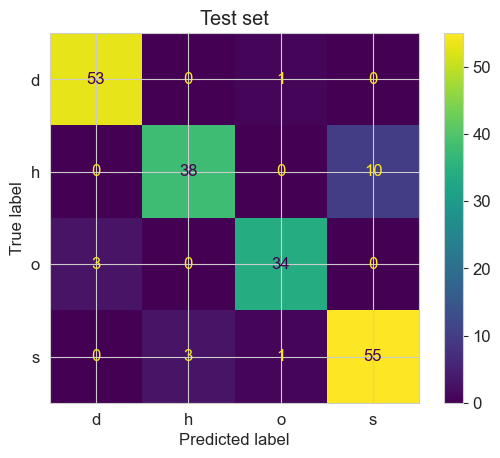

In [28]:
from sklearn.linear_model import LogisticRegression

#屏蔽特定的警告信息
import warnings
warnings.filterwarnings('ignore', message='Setting penalty=None will ignore the C and L1_ratio parameters')
#可能的触发情况：在 LogisticRegression 里，如果 penalty=None，那么 C 和 L1_ratio 这些正则化参数就会被忽略，而 sklearn 可能会发出警告。

warnings.filterwarnings('ignore', message="l1_ratio parameter is only used when penalty is 'elasticnet'")
#可能的触发情况：如果你在 LogisticRegression 里 没有 选择 penalty='elasticnet'，但仍然给了 l1_ratio，sklearn 可能会发出这个警告

model_softmax = helper_function(
    make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=1000, random_state=42, l1_ratio=0.5, solver='saga')),
    {
        'logisticregression__C': np.logspace(-3,3,7),# 7 个 C 值，在 10^(-3) 到 10^3 之间 按对数均匀分布
        # 即 array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
        'logisticregression__penalty': [None, 'l1', 'l2', 'elasticnet']
    }
)
#用于控制 L1 正则化（Lasso）和 L2 正则化（Ridge）的比例。l1_ratio=0.5 表示 L1 正则化和 L2 正则化各占 50%。
#选择优化算法，这里用的是 saga，它支持 L1、L2 和 ElasticNet 正则化，适用于大规模数据集

### Task 8 K-NN

optimal hyperparameter values: {'kneighborsclassifier__n_neighbors': 15}

 fold Validation F1
    1         0.833
    2         0.895
    3         0.812

Train accuracy: 0.858
Test accuracy: 0.904


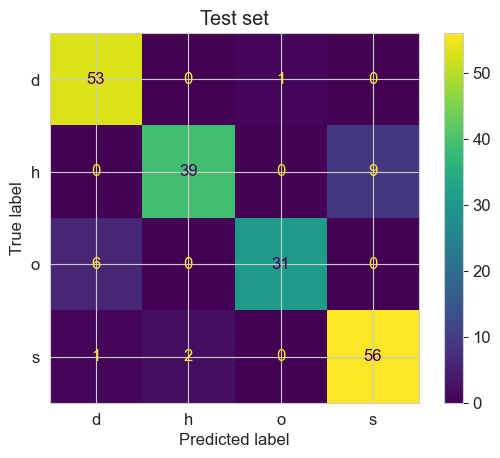

In [30]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = helper_function(
    make_pipeline(MinMaxScaler(), KNeighborsClassifier()),
    {
        'kneighborsclassifier__n_neighbors': np.linspace(1, 50, 11, dtype=int)
        # n_neighbors 代表 KNN 算法中最近邻的个数（K 值），即分类时参考的最近邻数据点数量。
        # np.linspace(1, 50, 11, dtype=int) 生成 1 到 50 之间的等间距 选取的 11 个整数
        # array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 50])
    }
)

### Task 9 comparison

- 如果关注测试集表现，Logistic Regression (0.909) > SVM (0.904) ≈ KNN (0.904)，但三者相差不大。
- 如果关注整体 F1 分数和训练稳定性，SVM 是最好的选择 (0.891 F1)。
- KNN 的训练准确率最低 (0.858)，可能是数据不够复杂，或者 n_neighbors=15 过高，导致决策边界太平滑。
- SVM 和 Logistic Regression 都选了 C=100，说明较弱的正则化效果更好。
- SVM 在训练集上的表现最好，但在测试集上略输 LogReg，可能是 LogReg 的泛化能力更稳定。

想要最稳定的测试集表现？ 选择 Logistic Regression ✅

想要最好的 Validation F1？ 选择 SVM ✅

数据量较小且非线性？ 可能 KNN 更适合 ✅